1. K-Means Clustering

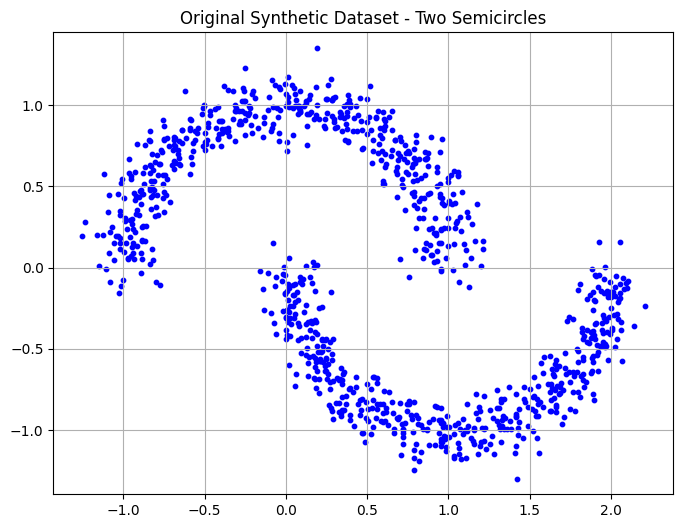

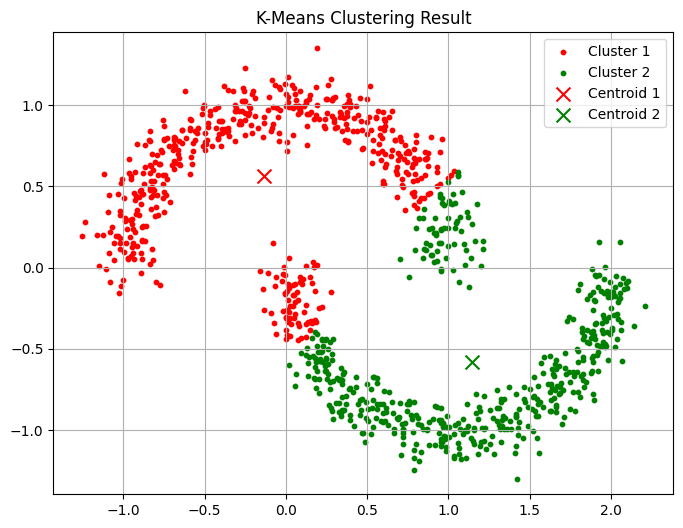

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt


# 1.1 Dataset Generation
# 500 theta values for semicircles
theta = np.linspace(0, np.pi, 500)
np.random.seed(123)

# First semicircle (center at (0, 0), facing downward)
semicircle1_x = np.cos(theta) + np.random.normal(0, 0.1, len(theta))
semicircle1_y = np.sin(theta) + np.random.normal(0, 0.1, len(theta))

# Second semicircle (center at (1, 0), facing upward)
semicircle2_x = 1 + np.cos(theta) + np.random.normal(0, 0.1, len(theta))
semicircle2_y = -np.sin(theta) + np.random.normal(0, 0.1, len(theta))

# Plotting original dataset
plt.figure(figsize=(8, 6))
plt.scatter(semicircle1_x, semicircle1_y, color='blue',s=10)
plt.scatter(semicircle2_x, semicircle2_y, color='blue',s=10)
plt.title("Original Synthetic Dataset - Two Semicircles")
plt.axis('equal')
plt.grid(True)
plt.show()

# Combine into one list of tuples
d1 = [(x, y) for x, y in zip(semicircle1_x, semicircle1_y)]
d2 = [(x, y) for x, y in zip(semicircle2_x, semicircle2_y)]
data_points = d1 + d2

# 1.2 K-Means Clustering
# Initializing centroids randomly from [-2, 3] x [-2, 2]
C_1 = (np.random.uniform(-2, 3), np.random.uniform(-2, 2))
C_2 = (np.random.uniform(-2, 3), np.random.uniform(-2, 2))

# Initializing mapping and other variables
mappings = {}
max_iters = 10000
current_iters = 0
num_points_updated = -1  # to enter the loop

# Euclidean distance function
def euclidean_distance(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

# 4. Initial cluster assignment
for point in data_points:
    mappings[point] = 0

# Iterative clustering
while num_points_updated != 0 and current_iters < max_iters:
    num_points_updated = 0
    cluster_1_points = []
    cluster_2_points = []

    for point in data_points:
        dist_to_C1 = euclidean_distance(point, C_1)
        dist_to_C2 = euclidean_distance(point, C_2)
        new_cluster = 1 if dist_to_C1 < dist_to_C2 else 2

        if mappings[point] != new_cluster:
            num_points_updated += 1
            mappings[point] = new_cluster

        if new_cluster == 1:
            cluster_1_points.append(point)
        else:
            cluster_2_points.append(point)

    # Updating centroids
    if cluster_1_points:
        x_coords, y_coords = zip(*cluster_1_points)
        C_1 = (np.mean(x_coords), np.mean(y_coords))
    if cluster_2_points:
        x_coords, y_coords = zip(*cluster_2_points)
        C_2 = (np.mean(x_coords), np.mean(y_coords))

    current_iters += 1

# Plotting clustered result

cluster_1_points = [point for point, cluster in mappings.items() if cluster == 1]
cluster_2_points = [point for point, cluster in mappings.items() if cluster == 2]

x1, y1 = zip(*cluster_1_points)
x2, y2 = zip(*cluster_2_points)

plt.figure(figsize=(8, 6))
plt.scatter(x1, y1, color='red', s=10, label='Cluster 1')
plt.scatter(x2, y2, color='green', s=10, label='Cluster 2')
plt.scatter(*C_1, color='red', marker='x', s=100, label='Centroid 1')
plt.scatter(*C_2, color='green', marker='x', s=100, label='Centroid 2')
plt.title("K-Means Clustering Result")
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()


2 K-Means++ Clustering on the Covertype Dataset

WC-SSD with K-Means++: 128158.21652541649
WC-SSD with Random Init: 129167.33334101623


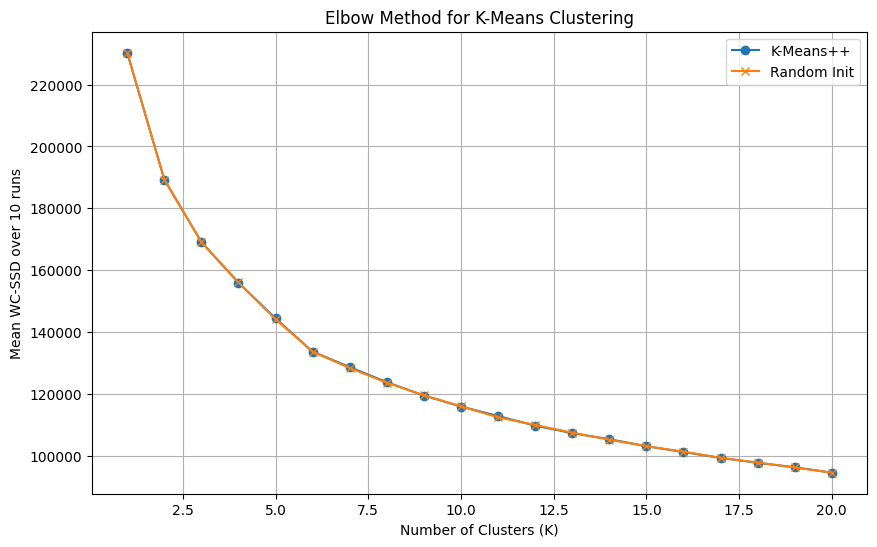

In [2]:
import numpy as np
from sklearn.datasets import fetch_covtype
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Data Preparation

# Load the dataset
data = fetch_covtype()
X_full = data.data
y_full = data.target

# Subsample exactly 20000 observations using seed 42
rng = np.random.default_rng(seed=42)
indices = rng.choice(X_full.shape[0], size=20000, replace=False)
X_sub = X_full[indices]
y_sub = y_full[indices]

# Standardize only the first 10 quantitative features
X_quant = X_sub[:, :10]
X_binary = X_sub[:, 10:]  # Do not standardize these

scaler = StandardScaler()
X_quant_scaled = scaler.fit_transform(X_quant)

# Concatenate standardized quantitative features and unstandardized binary features
X = np.hstack((X_quant_scaled, X_binary))  # Final data matrix: (20000, 54)


# K-Means++ Initialization and Clustering

def euclidean_distance(a, b):
    #Compute Euclidean distance between two arrays a and b.

    return np.linalg.norm(a - b, axis=1)

def kmeans_plus_plus_init(X, k):
    #Implements K-Means++ initialization.

    n_samples = X.shape[0]
    centroids = []

    # randomly choose the first centroid
    first_idx = np.random.choice(n_samples)
    centroids.append(X[first_idx])

    # Choose subsequent centroids
    for centroid_idx in range(1, k):
        dists = np.array([min([np.linalg.norm(x - c)**2 for c in centroids]) for x in X])
        probs = dists / dists.sum()
        cumulative_probs = np.cumsum(probs)
        r = np.random.rand()
        next_idx = np.searchsorted(cumulative_probs, r)
        centroids.append(X[next_idx])

    return np.array(centroids)

def kmeans(X, k, init='kmeans++', max_iters=500):
    # Implements the K-Means algorithm with the specified initialization method.

    if init == 'kmeans++':
        centroids = kmeans_plus_plus_init(X, k)
    elif init == 'random':
        centroids = X[np.random.choice(X.shape[0], k, replace=False)]
    else:
        raise ValueError("Unknown initialization method")

    for iteration in range(max_iters):
        # Assign clusters based on closest centroid
        distances = np.array([euclidean_distance(X, centroid) for centroid in centroids]).T
        labels = np.argmin(distances, axis=1)

        # Compute new centroids as the mean of points in each cluster
        new_centroids = np.array([X[labels == j].mean(axis=0) for j in range(k)])

        # Check for convergence (if centroids do not change)
        if np.allclose(centroids, new_centroids):
            break
        centroids = new_centroids

    return centroids, labels


# Evaluation (WC-SSD)

def compute_wcssd(X, centroids, labels):
    """
    Compute the within-cluster sum of squared distances (WC-SSD).
    """
    wcssd = 0
    for i in range(len(centroids)):
        cluster_points = X[labels == i]
        wcssd += ((cluster_points - centroids[i]) ** 2).sum()
    return wcssd

# Run K-Means++ (k=7)
centroids_kpp, labels_kpp = kmeans(X, k=7, init='kmeans++')

# Compute WC-SSD for K-Means++ run
wcssd_kpp = compute_wcssd(X, centroids_kpp, labels_kpp)
print("WC-SSD with K-Means++:", wcssd_kpp)

# Run Random initialization (baseline)
centroids_rand, labels_rand = kmeans(X, k=7, init='random')

# Compute WC-SSD for Random initialization run
wcssd_rand = compute_wcssd(X, centroids_rand, labels_rand)
print("WC-SSD with Random Init:", wcssd_rand)


# Elbow Method Analysis

def run_multiple_kmeans(X, k_values, runs=10, init_method='kmeans++'):

    # Run multiple K-Means clustering experiments and return the mean WC-SSD for each k.

    means = []
    for k in k_values:
        wcssd_runs = []
        for _ in range(runs):
            centroids, labels = kmeans(X, k, init=init_method)
            wcssd = compute_wcssd(X, centroids, labels)
            wcssd_runs.append(wcssd)
        means.append(np.mean(wcssd_runs))
    return means

# Run Elbow Method (k=1 to 20)
k_range = range(1, 21)
mean_wcssd_kpp = run_multiple_kmeans(X, k_range, runs=10, init_method='kmeans++')
mean_wcssd_rand = run_multiple_kmeans(X, k_range, runs=10, init_method='random')

# Plot WC-SSD for both K-Means++ and Random Init
plt.figure(figsize=(10, 6))
plt.plot(k_range, mean_wcssd_kpp, marker='o', label='K-Means++')
plt.plot(k_range, mean_wcssd_rand, marker='x', label='Random Init')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Mean WC-SSD over 10 runs')
plt.title('Elbow Method for K-Means Clustering')
plt.legend()
plt.grid(True)
plt.show()


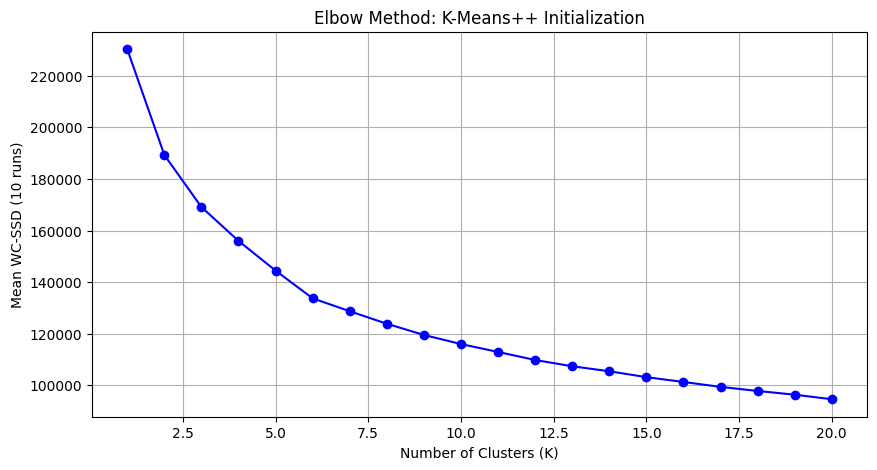

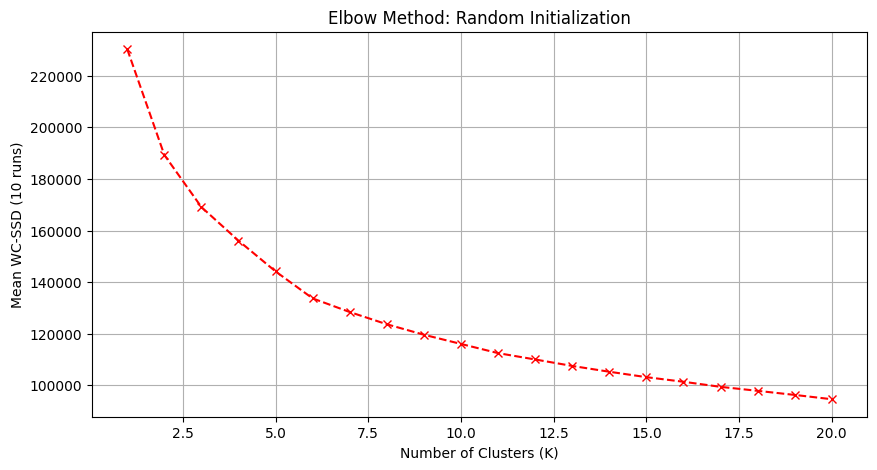

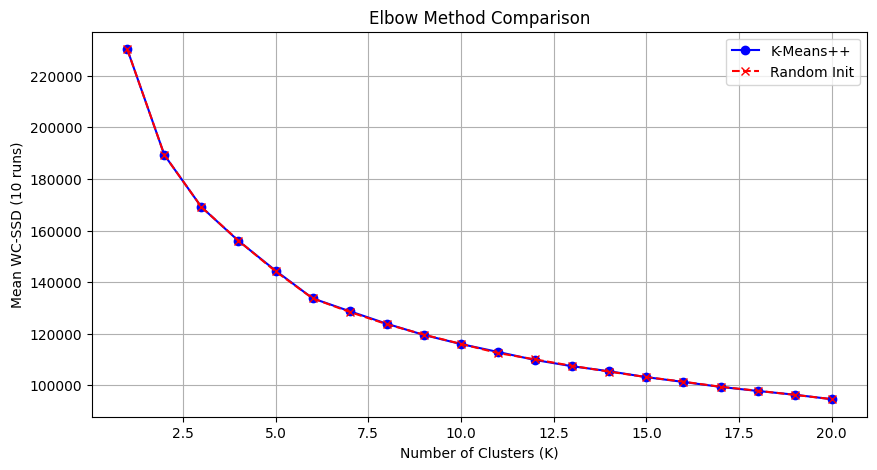

In [24]:
# Plot 1: Elbow Curve for K-Means++ only
plt.figure(figsize=(10, 5))
plt.plot(k_range, mean_wcssd_kpp, marker='o', linestyle='-', label='K-Means++',color='blue')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Mean WC-SSD (10 runs)')
plt.title('Elbow Method: K-Means++ Initialization')
plt.grid(True)
plt.show()

# Plot 2: Elbow Curve for Random Init only
plt.figure(figsize=(10, 5))
plt.plot(k_range, mean_wcssd_rand, marker='x', linestyle='--', label='Random Init', color='red')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Mean WC-SSD (10 runs)')
plt.title('Elbow Method: Random Initialization')
plt.grid(True)
plt.show()

# Plot 3: Overlay of Both Initializations
plt.figure(figsize=(10, 5))
plt.plot(k_range, mean_wcssd_kpp, marker='o', linestyle='-', label='K-Means++', color='blue')
plt.plot(k_range, mean_wcssd_rand, marker='x', linestyle='--', label='Random Init', color='red')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Mean WC-SSD (10 runs)')
plt.title('Elbow Method Comparison')
plt.legend()
plt.grid(True)
plt.show()


In [21]:
print("Comment on WC-SSD and Comparison\n")

print(" K-Means++ consistently produced lower WC-SSD values compared to random initialization across all values of K,\n indicating that K-Means++ is more effective at choosing initial centroids that lead to tighter, more coherent clusters.\n")
print(" When using the Elbow Method (running for K=1 to K=20), a sharp drop in WC-SSD is observed around K=6, \n suggesting that this is an optimal number of clusters for this dataset.\n")
print(" The comparison between K-Means++ and random initialization shows that while both methods converge to a \n similar final WC-SSD for larger K values, K-Means++ consistently leads to better cluster coherence at lower K values where initialization plays a crucial role.")

Comment on WC-SSD and Comparison

 K-Means++ consistently produced lower WC-SSD values compared to random initialization across all values of K,
 indicating that K-Means++ is more effective at choosing initial centroids that lead to tighter, more coherent clusters.

 When using the Elbow Method (running for K=1 to K=20), a sharp drop in WC-SSD is observed around K=6, 
 suggesting that this is an optimal number of clusters for this dataset.

 The comparison between K-Means++ and random initialization shows that while both methods converge to a 
 similar final WC-SSD for larger K values, K-Means++ consistently leads to better cluster coherence at lower K values where initialization plays a crucial role.
